# SmileGate Style Dataset을 이용한 텍스트 스타일 변경 모델

- https://github.com/smilegate-ai/korean_smile_style_dataset

## References
- https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/pipelines#transformers.Text2TextGenerationPipeline
- https://huggingface.co/docs/transformers/v4.20.1/en/model_doc/bart#transformers.BartForConditionalGeneration
- https://huggingface.co/docs/transformers/tasks/summarization
- https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/text_generation#transformers.generation_utils.GenerationMixin.generate.early_stopping
- https://huggingface.co/docs/transformers/internal/generation_utils


In [ ]:
!pip install transformers
!wget https://raw.githubusercontent.com/smilegate-ai/korean_smile_style_dataset/main/smilestyle_dataset.tsv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-10-20 03:49:31--  https://raw.githubusercontent.com/smilegate-ai/korean_smile_style_dataset/main/smilestyle_dataset.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2357401 (2.2M) [text/plain]
Saving to: ‘smilestyle_dataset.tsv.1’

smilestyle_dataset. 100%[===================>]   2.25M  --.-KB/s    in 0.01s   

2022-10-20 03:49:31 (213 MB/s) - ‘smilestyle_dataset.tsv.1’ saved [2357401/2357401]



In [ ]:
from google.colab import drive

drive.mount("/content/drive2")

Drive already mounted at /content/drive2; to attempt to forcibly remount, call drive.mount("/content/drive2", force_remount=True).


In [ ]:

from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
)
from tokenizers import Tokenizer
from typing import Dict, List, Optional
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from IPython.display import display
from typing import Dict

In [ ]:
df = pd.read_csv("smilestyle_dataset.tsv", sep="\t")
display(df.head())
display(df.isna().mean())
display(df.describe())
print(df.shape)

특정 문장을 다른 스타일의 문장으로 바꾸기 위해선, 한 row가 2개 이상의 NaN이 아닌 값이 있어야 한다. 

확인결과 5개의 행이 그냥 빈 행이여서 전부 NaN인데 이 값들을 제거해준다. 3475행이 3470행으로 바뀌었다.

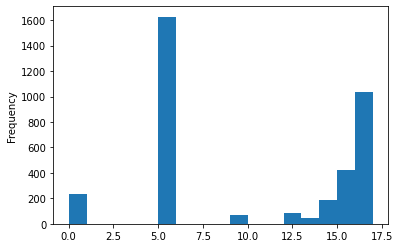

3470


In [ ]:
row_notna_count = df.notna().sum(axis=1)
row_notna_count.plot.hist(bins=row_notna_count.max())
plt.show()

df = df[row_notna_count >= 2]
print(len(df))

# 텍스트를 토큰화했을 때 길이가 어느정도인지 확인해보기

학습을 위해서는 특정 길이로 자른 뒤 padding 처리를 해주어야하는데, 그러기 위해선 학습 데이터들의 길이가 어느정도인지 파악이 필요하다.

In [ ]:
model_name = "gogamza/kobart-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


Downloading:   0%|          | 0.00/682k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


count    36793.000000
mean        13.147582
std          6.909344
min          1.000000
25%          8.000000
50%         12.000000
75%         17.000000
max        318.000000
dtype: float64

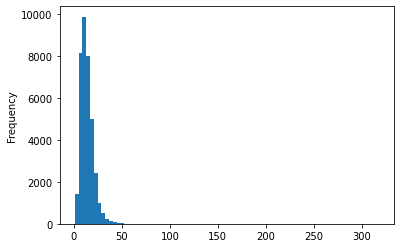

In [ ]:
lengths = []

for column in df.columns:
  out = tokenizer(df[column][df[column].notna()].tolist())
  out = [len(x) for x in out['input_ids']]
  lengths.extend(out)

lengths = pd.Series(lengths)
display(lengths.describe())
lengths.plot.hist(bins=80)

정말 긴 문장도 있지만 대부분 토큰 길이가 50아래인 것을 볼 수 있다.

# Dataset class 만들기

In [ ]:
style_map = {
    'formal': '문어체',
    'informal': '구어체',
    'android': '안드로이드',
    'azae': '아재',
    'chat': '채팅',
    'choding': '초등학생',
    'emoticon': '이모티콘',
    'enfp': 'enfp',
    'gentle': '신사',
    'halbae': '할아버지',
    'halmae': '할머니',
    'joongding': '중학생',
    'king': '왕',
    'naruto': '나루토',
    'seonbi': '선비',
    'sosim': '소심한',
    'translator': '번역기'
}

학습에 필요한 Dataset을 만든다, 여러 스타일을 가진 한 문장을 가져온 뒤, 두가지 스타일을 임의로 추출해서 하나를 원본 문장으로 지정하고 encoder의 입력으로 사용하고, 다른 하나를 목표 문장으로 decoder의 입력으로 사용한다.

In [ ]:

class TextStyleTransferDataset(Dataset):
  def __init__(self, 
               df: pd.DataFrame, 
               tokenizer: Tokenizer
               ):
    self.df = df
    self.tokenizer = tokenizer
    
  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index, :].dropna().sample(2)
    text1 = row[0]
    text2 = row[1]
    target_style = row.index[1]
    target_style_name = style_map[target_style]

    encoder_text = f"{target_style_name} 말투로 변환:{text1}"
    decoder_text = f"{text2}{self.tokenizer.eos_token}"
    model_inputs = self.tokenizer(encoder_text, max_length=64, truncation=True)

    with self.tokenizer.as_target_tokenizer():
      labels = tokenizer(decoder_text, max_length=64, truncation=True)
    model_inputs['labels'] = labels['input_ids']
    del model_inputs['token_type_ids']

    return model_inputs

In [ ]:
dataset = TextStyleTransferDataset(df, tokenizer)
out = dataset[0]
print(out['input_ids'])
print(out['labels'])
print(tokenizer.decode(out['input_ids']))
print(tokenizer.decode(out['labels']))

out = dataset[1]
print(out['input_ids'])
print(out['labels'])
print(tokenizer.decode(out['input_ids']))
print(tokenizer.decode(out['labels']))

In [ ]:
from sklearn.model_selection import train_test_split

# 학습을 위해 train, test set으로 나눈다.
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
print(len(df_train), len(df_test))

3123 347


In [ ]:
train_dataset = TextStyleTransferDataset(
    df_train,
    tokenizer
)
test_dataset = TextStyleTransferDataset(
    df_test,
    tokenizer
)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer, model=model
)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


Downloading:   0%|          | 0.00/496M [00:00<?, ?B/s]

In [ ]:
model_path = "/content/drive/MyDrive/data/text-transfer-smilegate-bart-eos/"

training_args = Seq2SeqTrainingArguments(
    output_dir=model_path, #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=24, # number of training epochs
    per_device_train_batch_size=16, # batch size for training
    per_device_eval_batch_size=16,  # batch size for evaluation
    eval_steps=500, # Number of update steps between two evaluations.
    save_steps=1000, # after # steps model is saved 
    warmup_steps=300,# number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    evaluation_strategy="steps",
    save_total_limit=3
    )

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3123
  Num Epochs = 24
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4704
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,2.677100,1.795796
1000,1.607800,1.679782
1500,1.361900,1.476760
2000,1.247100,1.622253
2500,1.132300,1.453199
3000,1.054100,1.483403
3500,0.997300,1.540496
4000,0.961800,1.391239
4500,0.913900,1.600054


***** Running Evaluation *****
  Num examples = 347
  Batch size = 16
***** Running Evaluation *****
  Num examples = 347
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/data/text-transfer-smilegate-bart-eos/checkpoint-1000
Configuration saved in /content/drive/MyDrive/data/text-transfer-smilegate-bart-eos/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/data/text-transfer-smilegate-bart-eos/checkpoint-1000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3543: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "
***** Running Evaluation *****
  Num e

TrainOutput(global_step=4704, training_loss=1.3090941078808842, metrics={'train_runtime': 901.8418, 'train_samples_per_second': 83.11, 'train_steps_per_second': 5.216, 'total_flos': 1551738795909120.0, 'train_loss': 1.3090941078808842, 'epoch': 24.0})

In [ ]:
trainer.save_model("/content/drive/MyDrive/data/text-transfer-smilegate-bart-eos/")

Saving model checkpoint to /content/drive/MyDrive/data/text-transfer-smilegate-bart-eos/
Configuration saved in /content/drive/MyDrive/data/text-transfer-smilegate-bart-eos/config.json
Model weights saved in /content/drive/MyDrive/data/text-transfer-smilegate-bart-eos/pytorch_model.bin


# Pipeline을 이용해서 학습한 모델로 텍스트 생성해보기

In [ ]:
from transformers import pipeline

nlg_pipeline = pipeline('text2text-generation',model=model_path, tokenizer=model_name)

loading configuration file /content/drive/MyDrive/data/text-transfer-smilegate-bart-eos/config.json
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
Model config BartConfig {
  "_name_or_path": "/content/drive/MyDrive/data/text-transfer-smilegate-bart-eos/",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 1,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.1,
  "d_model": 768,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 1,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0

In [ ]:
def generate_text(pipe, text, target_style, num_return_sequences=5, max_length=60):
  target_style_name = style_map[target_style]
  text = f"{target_style_name} 말투로 변환:{text}"
  out = pipe(text, num_return_sequences=num_return_sequences, max_length=max_length)
  return [x['generated_text'] for x in out]

In [ ]:
target_styles = df.columns
src_text = "과제가 너무 빡세다"

print("입력 문장:", src_text)
for style in target_styles:
  print(style, generate_text(nlg_pipeline, src_text, style, num_return_sequences=1, max_length=1000)[0])

입력 문장: 과제가 너무 빡세다
formal 과제가 너무 빡납니다.
informal 과제가 너무 많아.
android 과제. 힘듬.
azae 과제 너무빡하구만
chat 과제 너무빡셈
choding 과제 넘빡셈
emoticon 과제 너무 너무 많아...(⊙_⊙;)
enfp 과제 넘빡~?
gentle 과제가 너무 빡납니다.
halbae 과제 너무 너무 많은 것 같구먼...
halmae 과제 지빡하게 풀렸네
joongding 과제 너무빡셈
king 과제가 너무 힘들구려.
naruto 너무 힘들 과제라니깐!
seonbi 과제가 너무 힘들 것 같소...
sosim 과제 너무빡세..
translator 그것은 아주 힘든 과제입니다.


In [ ]:
print(generate_text(nlg_pipeline, src_text, target_styles[1], num_return_sequences=1, max_length=1000)[0])

과제가 너무 많아.


### 챗봇 데이터 읽고 없는 데이터 정리하기

In [ ]:
df_wellness = pd.read_csv("wellness_dataset_original.csv")

df_wellness

FileNotFoundError: ignored

## unnamed 3 삭제

In [ ]:
df_wellness = df_wellness.drop(columns=['Unnamed: 3'])


## 챗봇 답변 없는거 삭제

In [ ]:
df_wellness= df_wellness[~df_wellness['챗봇'].isna()]

df_wellness.head()

In [ ]:
chatbot=df_wellness['챗봇']
df_chatbot = pd.DataFrame(chatbot)
list_chatbot = df_chatbot['챗봇'].tolist()

## 데이터프레임 인덱스 초기화한 후 순서대로 정렬

In [ ]:
df_wellness_reset=df_wellness.reset_index(drop=True)
df_wellness_reset

## df 반말챗봇 컬럼에 하나씩 변환해서 추가하기 

In [ ]:
i = 0
for chat in df_wellness_reset['챗봇']:
  df_wellness_reset.loc[ i, '반말챗봇']= generate_text(nlg_pipeline, chat, target_styles[1], num_return_sequences=1, max_length=1000)[0]
  print(generate_text(nlg_pipeline, chat, target_styles[1], num_return_sequences=1, max_length=1000)[0])
  i +=1

### 마지막으로 저장하고 끝

In [ ]:
df_wellness_reset.to_csv('wellness_dataset_informal2.csv')